In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style ("white")
import numpy as np

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

CONTROL = "#F95700FF"
TREATED = "#00A4CCFF"
palette_anc = [CONTROL, TREATED]
order=["control","treated"]

SOURCE_WT_FORMS = "Source: intervention forms"
SOURCE_REG = "Source: Facilities' registry book (Gov. of Mozambique)"

SIZE_REG_BOOK = "n = 3389(Control) 3109 (Treated)"

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

cleaned_files_path = f"{ROOT}/anc/csv_cleaned"
CLEANED_DATA_PATH = f"{ROOT}/cleaned_data"
AUX = f"{ROOT}/aux"

anc_path = f"{CLEANED_DATA_PATH}/anc_cpn_endline_v20230611.csv"
anc = pd.read_csv(anc_path)

img = "graphs"

def format_graph():
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

complier_df = pd.read_stata(f"{CLEANED_DATA_PATH}/complier.dta")
facility_characteristics = pd.read_stata(f"{AUX}/facility_characteristics.dta")

volume_baseline = pd.read_stata(f"{AUX}/facility_volume_baseline.dta")

complier_df = complier_df.merge(facility_characteristics, on=["facility_cod", "treatment"])
complier_df = complier_df.merge(volume_baseline, on=["facility_cod"])


def column_by_quantile(df, col, n_quantiles,n_round=2,format_int=True):
    """
        Divide the column in quantiles and generate a label
    """
    quantiles = np.linspace(0,1,n_quantiles+1)

    conditions = []
    labels = []
    for i,q in enumerate(quantiles[0:(n_quantiles)]):
        v = np.quantile(df[col], q)
        v_next = np.quantile(df[col], quantiles[i+1])

        # if last, changes comparison to lower or equal
        if i == n_quantiles-1:
            conditions.append( (df[col] >= v) & (df[col] <= v_next) )
        else:
            conditions.append( (df[col] >= v) & (df[col] < v_next) )

        if format_int:
            lower_bound = int(round(v,n_round))
            upper_bound = int(round(v_next,n_round))
        else:
            lower_bound = round(v,n_round)
            upper_bound = round(v_next,n_round)

        label = f"{lower_bound}-{upper_bound}"
        labels.append(label)
        
    return np.select(conditions, labels),labels

def size_1st(anc):
    len_c = len(anc.query("consultation_reason == 1 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 1 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

def size_followup(anc):
    len_c = len(anc.query("consultation_reason == 2 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 2 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

def size_anc(anc):
    len_c = len(anc.query("consultation_reason == 2 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 2 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

<ipython-input-2-7e22e3f877e8>:26: DtypeWarning: Columns (33,34,120) have mixed types. Specify dtype option on import or set low_memory=False.
  anc = pd.read_csv(anc_path)


In [309]:
complier_df.query("treatment == 1").groupby("prep").size()


prep
0.1-0.6      8
0.6-0.77    18
0.77-1.0    12
dtype: int64

In [310]:
complier_df.query("treatment == 1 & complier == 1").groupby("prep").size()

prep
0.1-0.6      7
0.6-0.77    12
0.77-1.0     6
dtype: int64

In [161]:
import numpy as np
import geopandas as gpd

facility_characteristics = facility_characteristics.rename(
                            columns={"Q013_B":"lat",
                                     "Q014_B":"lon"})
fac_char = facility_characteristics[["facility_cod", "treatment",
                                     "lat", "lon"]]
fac_char["lat"] = fac_char["lat"].str.strip()
fac_char["lon"] = fac_char["lon"].str.strip()
fac_char = fac_char.query("lat != '' ")

fac_char["lat"] = fac_char["lat"].astype(float)
fac_char["lon"] = fac_char["lon"].astype(float)

gdf = gpd.GeoDataFrame(
    fac_char[["facility_cod", "treatment", "lat","lon"]],
    geometry=gpd.points_from_xy(x=fac_char.lon,
                                      y=fac_char.lat),
    crs='epsg:4326'
)
gdf = gdf.set_index("facility_cod")
gdf_utm = gdf.to_crs(epsg=32631)

for i,row in gdf_utm.iterrows():
    distances = {"facility_cod":[],
                 "close_fac_treated":[],
                 "distance":[]}

    for j,row_j in gdf_utm.drop(i).iterrows():
        distance = round(row.geometry.distance(row_j.geometry),0)/1000
        distances["facility_cod"].append(j)
        distances["distance"].append(distance)
        distances["close_fac_treated"].append(row_j["treatment"])

    distances_df = pd.DataFrame(distances)
    close_fac = distances_df.loc[ distances_df["distance"] == distances_df["distance"].min() ]

    gdf_utm.loc[i, "min_distance_fac"] = close_fac["facility_cod"].iloc[0]
    gdf_utm.loc[i, "min_distance"] = close_fac["distance"].iloc[0]
    gdf_utm.loc[i, "close_fac_treated"] = close_fac["close_fac_treated"].iloc[0]

gdf_utm["close_5"] = 0
close_5 = gdf_utm.eval("treatment == 0 & min_distance <= 5 & close_fac_treated == 1 ")
gdf_utm.loc[close_5, "close_5"] = 1

gdf_utm = gdf_utm.reset_index()[["facility_cod", "min_distance_fac", "min_distance", "close_fac_treated", "close_5"]].reset_index()
facility_characteristics = facility_characteristics.merge(gdf_utm,
                                           on="facility_cod",
                                           how="left")

<ipython-input-161-a58a153b23a2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac_char["lat"] = fac_char["lat"].str.strip()
<ipython-input-161-a58a153b23a2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac_char["lon"] = fac_char["lon"].str.strip()


In [170]:
anc = anc.merge(gdf_utm,
                left_on="facility",
                right_on="facility_cod",
                how="left")

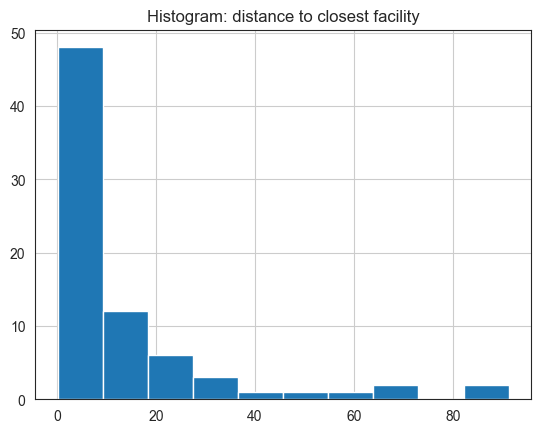

In [175]:
plt.figure()
gdf_utm["min_distance"].hist()
plt.title("Histogram: distance to closest facility")
plt.show()

In [207]:
anc.query("consultation_reason == 2 & province=='Maputo Cidade'").groupby("treatment")["waiting_time"].mean()

treatment
0    142.670973
1     98.019811
Name: waiting_time, dtype: float64

## GRAPHS

<ipython-input-204-e7d7238aa9c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  followup["urban_labeled"] = followup["urban"]


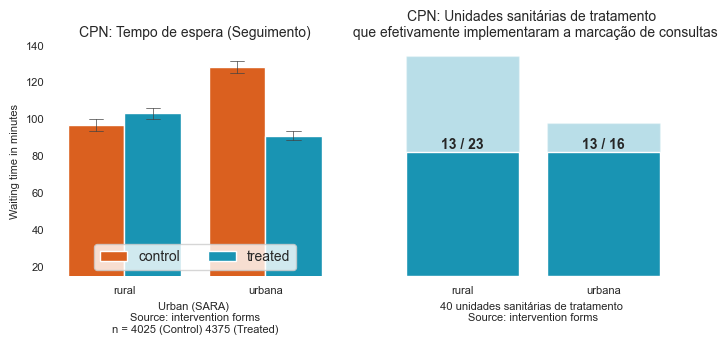

In [204]:
followup = anc.query("consultation_reason == 2")

followup["urban_labeled"] = followup["urban"]
followup = followup.replace({"urban_labeled":{0:"rural", 1:"urbana"}})

order_urban = ["rural", "urbana"]

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
g = sns.barplot(followup, x="urban_labeled",
            y="waiting_time",
            hue="treatment_status",
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("CPN: Tempo de espera (Seguimento)" ,fontsize=10)

plt.xlabel("Urban (SARA) \n" + SOURCE_WT_FORMS + "\n" + size_followup(anc), size=8)
sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)
plt.ylabel("Waiting time in minutes", fontsize=8)
plt.ylim([15,140])
format_graph()

plt.subplot(1, 2, 2)


complier_df["urban_labeled"] = complier_df["urban"]
complier_df = complier_df.replace({"urban_labeled":{0:"rural", 1:"urbana"}})

order_urban = ["rural", "urbana"]
sns.countplot(complier_df.query("treatment == 1"), x="urban_labeled", 
            color=TREATED, order=order_urban, **dict(alpha=0.3))
ax = sns.countplot(complier_df.query("treatment == 1 & complier == 1"),
                    x="urban_labeled", order=order_urban, color=TREATED)
ax.text(0, 13.3, "13 / 23", ha='center', weight='bold')
ax.text(1, 13.3, "13 / 16", ha='center',weight='bold')

title="CPN: Unidades sanitárias de tratamento \n que efetivamente implementaram a marcação de consultas"
plt.title(title ,fontsize=10)
plt.xlabel("40 unidades sanitárias de tratamento \n" + SOURCE_WT_FORMS, size=8)
sns.despine(left=True, bottom=True)
plt.ylabel("Percentage of patientes", fontsize=8)
format_graph()
plt.yticks([])
plt.ylabel("")

plt.show()

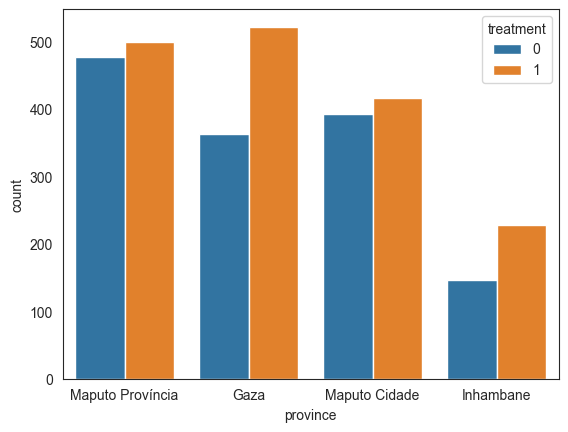

In [190]:
sns.countplot(anc.query("consultation_reason == 1"), x="province", hue="treatment")
plt.show()

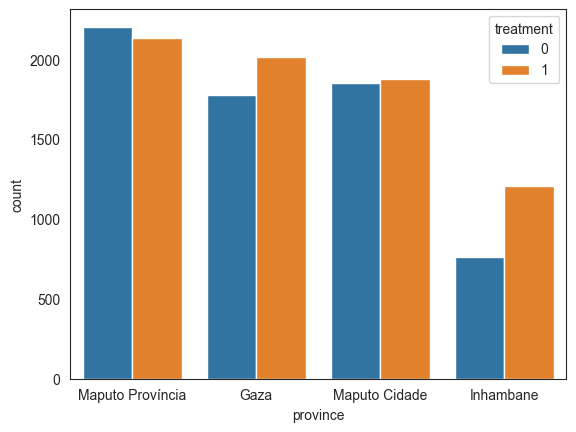

In [208]:
sns.countplot(anc, x="province", hue="treatment")
plt.show()

In [217]:
(
anc.query("consultation_reason == 1")
    .groupby(["treatment", "urban"])
    ["waiting_time"].std()
)

treatment  urban
0          0.0      79.845686
           1.0      91.495674
1          0.0      79.758976
           1.0      68.398996
Name: waiting_time, dtype: float64

In [218]:
(
anc.query("consultation_reason == 2")
    .groupby(["treatment", "urban"])
    ["waiting_time"]
    .std()
)

treatment  urban
0          0.0      66.168952
           1.0      78.908427
1          0.0      73.518194
           1.0      60.835890
Name: waiting_time, dtype: float64